In [1460]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd

df = pd.read_csv("/Users/suyashgoel/product-recommendation/shopping_behavior_updated.csv")

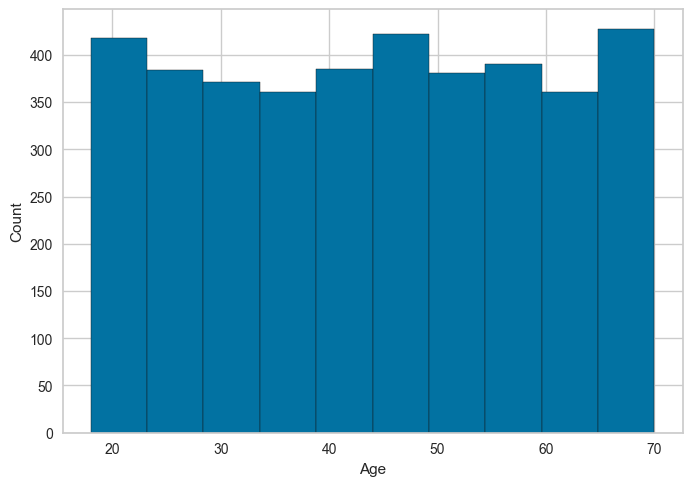

In [1461]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.hist(df['Age'], bins= 10, edgecolor= 'k', alpha = 1.0)
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [1462]:
selected_features_df = df[['Age','Gender', 'Location', 'Season', 'Subscription Status', 'Previous Purchases', 'Frequency of Purchases']]

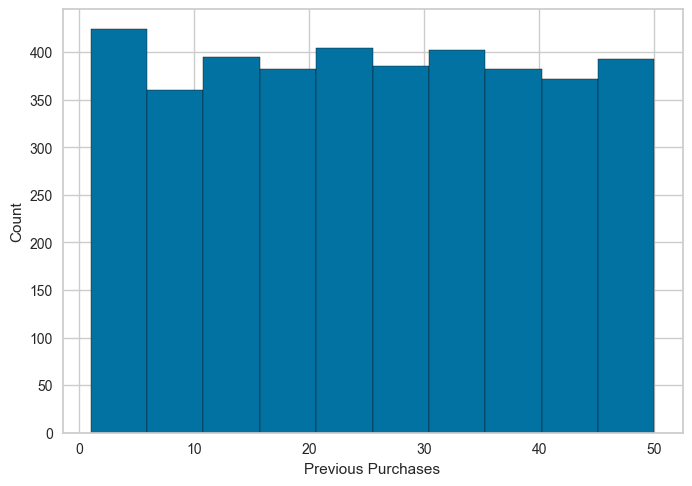

In [1463]:
plt.hist(df['Previous Purchases'], bins= 10, edgecolor= 'k', alpha = 1.0)
plt.xlabel('Previous Purchases')
plt.ylabel('Count')
plt.show()

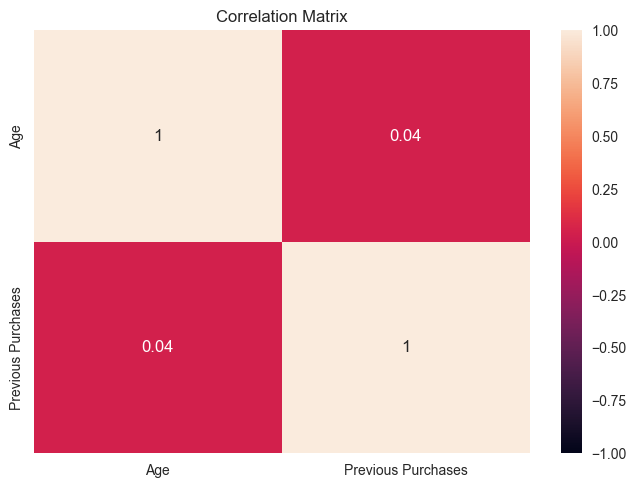

In [1464]:
plt.figure()
sns.heatmap(selected_features_df.select_dtypes(include=['int', 'float']).corr(), vmin = -1, vmax = 1, annot= True)
plt.title('Correlation Matrix')
plt.show()

In [1465]:
#cramers v for categorical variables
from scipy.stats import chisquare, chi2_contingency
import math
import numpy as np

def cramers(df):
    num_cols = df.shape[1]
    cramer_matrix = np.zeros((num_cols, num_cols))
    for cat1 in range(num_cols):
        for cat2 in range(num_cols):
            ct = pd.crosstab(df[df.columns[cat1]], df[df.columns[cat2]])
            c, p, dof, expected = chi2_contingency(ct) 
            n = sum(np.sum(ct))
            k = min(ct.shape)
            cramer_matrix[cat1, cat2] = math.sqrt(c / (n * k))
    cramer_matrix = pd.DataFrame(cramer_matrix, columns=df.columns, index=df.columns)
    return cramer_matrix

<Axes: >

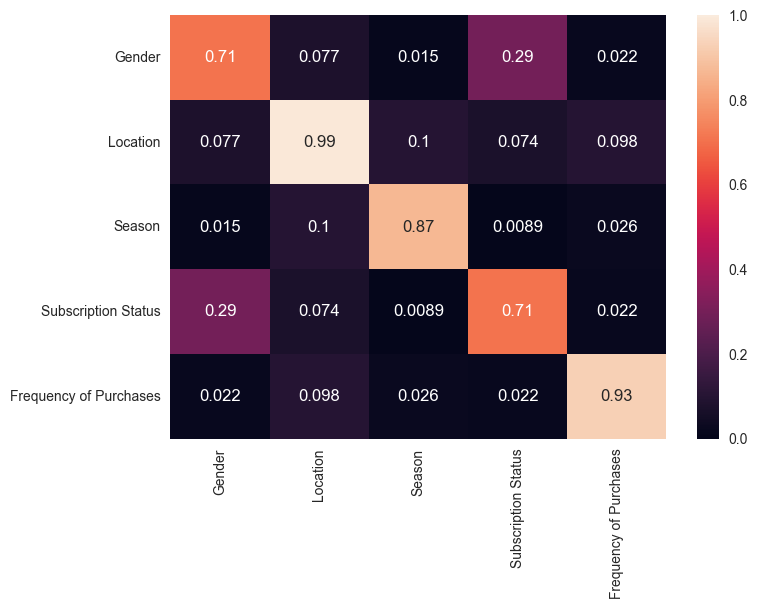

In [1466]:
cat_var = selected_features_df.select_dtypes('object')

sns.heatmap(cramers(cat_var), vmin = 0, vmax = 1, annot= True)

In [1467]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
scaled_df = pd.concat([selected_features_df["Age"], selected_features_df["Previous Purchases"]], axis=1)

sc.fit(scaled_df)
scaled_df = sc.transform(scaled_df)

scaled_df = pd.DataFrame(scaled_df, columns= ["Age", "Previous Purchases"])

scaled_df = pd.concat([scaled_df, selected_features_df['Gender'], selected_features_df['Location'], selected_features_df['Season'], selected_features_df['Subscription Status'], selected_features_df['Frequency of Purchases']], axis=1)

In [1468]:
gender = pd.get_dummies(selected_features_df['Gender'], drop_first=True, dtype=int)
loc = pd.get_dummies(selected_features_df['Location'], drop_first=True, dtype=int)
season = pd.get_dummies(selected_features_df['Season'], drop_first=True, dtype=int)
status = pd.get_dummies(selected_features_df['Subscription Status'], drop_first=True, dtype=int)
freq = pd.get_dummies(selected_features_df['Frequency of Purchases'], drop_first=True, dtype=int)

encoded_and_scaled_df = scaled_df
encoded_and_scaled_df = pd.concat([scaled_df, gender, loc, season, status, freq], axis=1)

encoded_and_scaled_df.drop(columns=['Gender', 'Location', 'Season', 'Subscription Status', 'Frequency of Purchases'], inplace=True)

In [1469]:
encoded_and_scaled_df.head

<bound method NDFrame.head of            Age  Previous Purchases  Male  Alaska  Arizona  Arkansas  \
0     0.718913           -0.785831     1       0        0         0   
1    -1.648629           -1.616552     1       0        0         0   
2     0.390088           -0.162789     1       0        0         0   
3    -1.517099            1.637107     1       0        0         0   
4     0.061263            0.391025     1       0        0         0   
...        ...                 ...   ...     ...      ...       ...   
3895 -0.267563            0.460252     0       0        0         0   
3896  0.521618            1.083293     0       0        0         0   
3897  0.127028           -0.093563     0       0        0         0   
3898 -0.004502           -0.093563     0       0        0         0   
3899  0.521618            0.529479     0       0        0         0   

      California  Colorado  Connecticut  Delaware  ...  Spring  Summer  \
0              0         0            0    

In [1470]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(encoded_and_scaled_df)

pca_df = pd.DataFrame(pca.transform(encoded_and_scaled_df), columns=['PC1','PC2', 'PC3'])

In [1471]:
from sklearn.cluster import KMeans

num_clusters = int(input('Enter the number of clusters you want to segment users into based on their demographics. This must be more than the number of recommendations you want.'))

kmeans = KMeans(n_clusters = num_clusters, init = 'k-means++')

kmeans.fit(pca_df)

labels = kmeans.predict(pca_df)

df["Clusters"] = labels

In [1472]:
# df[['Age','Gender', 'Location', 'Season', 'Subscription Status', 'Previous Purchases', 'Frequency of Purchases']]

age = int(input('Enter the age of an existing customer you want recommendations for'))
gender = input('Enter the gender of the customer')
location = input('Enter the US State the customer resides in')
season = input('Enter the season the customer is making a purchase during')
subscription_status = input('Provide the subscription status of the user')
previous_purchases = int(input('Enter the number of purchases the customer the customer has made'))
frequency_of_purchases = input('Enter the frequency at which the customer makes purchases')

row = [age, gender, location, season, subscription_status, previous_purchases, frequency_of_purchases]

sample = pd.DataFrame([row], columns=['Age','Gender', 'Location', 'Season', 'Subscription Status', 'Previous Purchases', 'Frequency of Purchases'])

sample

,Age,Gender,Location,Season,Subscription Status,Previous Purchases,Frequency of Purchases
0,22,Female,California,Winter,No,24,Quarterly


In [1473]:

# Scale numeric featurescaled_sample = pd.DataFrame(StandardScaler().fit_transform(sample[['Age', 'Previous Purchases']]), columns=['Age', 'Previous Purchases'])

scaled_sample = pd.DataFrame(sc.transform(sample[['Age', 'Previous Purchases']]), columns=['Age', 'Previous Purchases'])

sample.drop(columns=['Age', 'Previous Purchases'], inplace=True)

sample = pd.concat([sample, scaled_sample], axis=1)

In [1474]:
sample

,Gender,Location,Season,Subscription Status,Frequency of Purchases,Age,Previous Purchases
0,Female,California,Winter,No,Quarterly,-1.451334,-0.093563


In [1475]:
bin_cols = list(encoded_and_scaled_df.columns)
bin_cols = bin_cols[2:len(bin_cols)]

for col in bin_cols:
    if sample['Gender'][0] in col or sample['Location'][0] in col or sample['Season'][0] in col or sample['Subscription Status'][0] in col or sample['Frequency of Purchases'][0] in col:
        new_col = pd.DataFrame([1], columns=[col])
    else:
        new_col = pd.DataFrame([0], columns=[col])
    sample = pd.concat([sample, new_col], axis=1)

sample.drop(columns=['Gender', 'Location', 'Season', 'Subscription Status', 'Frequency of Purchases'], inplace=True)

In [1476]:
sample

,Age,Previous Purchases,Male,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,Spring,Summer,Winter,Yes,Bi-Weekly,Every 3 Months,Fortnightly,Monthly,Quarterly,Weekly
0,-1.451334,-0.093563,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [1477]:
pca_sample = pd.DataFrame(pca.transform(sample), columns=['PC1','PC2', 'PC3'])

pca_sample

,PC1,PC2,PC3
0,1.094073,-0.971821,-0.70293


In [1478]:
[cluster] = kmeans.predict(pca_sample)

cluster

37

In [1479]:
df.loc[df['Clusters'] == cluster]

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases,Clusters
2670,2671,30,Female,Sunglasses,Accessories,44,Pennsylvania,M,Yellow,Fall,4.7,No,Express,No,No,26,Bank Transfer,Bi-Weekly,37
2678,2679,33,Female,Belt,Accessories,91,Montana,M,Magenta,Spring,3.4,No,2-Day Shipping,No,No,34,Credit Card,Bi-Weekly,37
2700,2701,22,Female,T-shirt,Clothing,68,California,XL,Olive,Winter,3.2,No,Standard,No,No,36,Cash,Weekly,37
2715,2716,25,Female,Sneakers,Footwear,92,Mississippi,XL,Pink,Winter,4.1,No,Express,No,No,29,PayPal,Fortnightly,37
2722,2723,23,Female,Hat,Accessories,83,Maine,M,Green,Spring,2.8,No,2-Day Shipping,No,No,22,PayPal,Fortnightly,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3858,3859,30,Female,T-shirt,Clothing,77,Missouri,M,Olive,Winter,3.5,No,Store Pickup,No,No,26,Credit Card,Quarterly,37
3865,3866,25,Female,Shorts,Clothing,42,Nebraska,M,Olive,Spring,4.2,No,Store Pickup,No,No,28,Cash,Every 3 Months,37
3869,3870,26,Female,Coat,Outerwear,64,Arizona,L,Cyan,Spring,3.8,No,Free Shipping,No,No,28,Bank Transfer,Annually,37
3890,3891,35,Female,Shirt,Clothing,81,Nebraska,XL,Green,Winter,2.6,No,Standard,No,No,33,Debit Card,Annually,37


In [1480]:
similar_customers = df.loc[df["Clusters"] == cluster]

potential_recommendations = similar_customers[df['Review Rating'] >= 3]

/var/folders/5l/7bmxvb2x6sq3y8958yv03lq40000gn/T/ipykernel_3843/280060047.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  potential_recommendations = similar_customers[df['Review Rating'] >= 3]


In [1481]:
items = potential_recommendations['Item Purchased'].value_counts()

items

Item Purchased
Hat           8
Socks         7
Sweater       7
Sunglasses    6
Boots         6
Sneakers      5
Blouse        5
Coat          5
Backpack      4
Belt          4
Skirt         4
Shorts        4
Handbag       4
Dress         4
Gloves        3
T-shirt       3
Jacket        2
Hoodie        2
Pants         2
Jeans         1
Shoes         1
Sandals       1
Shirt         1
Scarf         1
Jewelry       1
Name: count, dtype: int64

In [1482]:
potential_recommendations

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases,Clusters
2670,2671,30,Female,Sunglasses,Accessories,44,Pennsylvania,M,Yellow,Fall,4.7,No,Express,No,No,26,Bank Transfer,Bi-Weekly,37
2678,2679,33,Female,Belt,Accessories,91,Montana,M,Magenta,Spring,3.4,No,2-Day Shipping,No,No,34,Credit Card,Bi-Weekly,37
2700,2701,22,Female,T-shirt,Clothing,68,California,XL,Olive,Winter,3.2,No,Standard,No,No,36,Cash,Weekly,37
2715,2716,25,Female,Sneakers,Footwear,92,Mississippi,XL,Pink,Winter,4.1,No,Express,No,No,29,PayPal,Fortnightly,37
2729,2730,31,Female,Gloves,Accessories,71,Montana,S,Violet,Summer,4.1,No,Free Shipping,No,No,32,Credit Card,Monthly,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3850,3851,27,Female,Jewelry,Accessories,74,Mississippi,L,Indigo,Summer,4.4,No,2-Day Shipping,No,No,25,Debit Card,Every 3 Months,37
3858,3859,30,Female,T-shirt,Clothing,77,Missouri,M,Olive,Winter,3.5,No,Store Pickup,No,No,26,Credit Card,Quarterly,37
3865,3866,25,Female,Shorts,Clothing,42,Nebraska,M,Olive,Spring,4.2,No,Store Pickup,No,No,28,Cash,Every 3 Months,37
3869,3870,26,Female,Coat,Outerwear,64,Arizona,L,Cyan,Spring,3.8,No,Free Shipping,No,No,28,Bank Transfer,Annually,37


In [1483]:
num_recs = int(input('Enter the number of recommendations you want for the customer'))

print("Here are your top", num_recs, "recommendations based on what similar customers have been satisifed with!")

for i in range(num_recs):
    print(items.index[i])

Here are your top 5 recommendations based on what similar customers have been satisifed with!
Hat
Socks
Sweater
Sunglasses
Boots


In [1484]:
for index in df.index:
    if df.loc[index, 'Clusters'] == cluster:
        df.loc[index, 'Colors'] = 'orange'
    else:
        df.loc[index, 'Colors'] = 'blue'

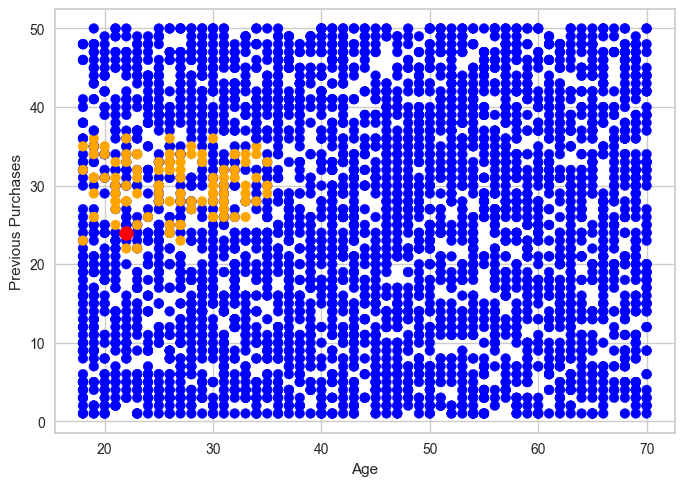

In [1485]:
var_names = [('Age', age), ('Gender', gender), ('Location', location), ('Season', season), ('Subscription Status', subscription_status), ('Previous Purchases', previous_purchases), ('Frequency of Purchases', frequency_of_purchases)]

feature_one = input('Enter the first feature you want to plot')
feature_two = input('Enter the second feature you want to plot')

features_to_plot = []

for tuple in var_names:
    if tuple[0] == feature_one or tuple[0] == feature_two:
        features_to_plot.append(tuple[1])

plt.scatter(df[feature_one], df[feature_two], c=df['Colors'])

sample_feature_one = features_to_plot[0]
sample_feature_two = features_to_plot[1]

plt.scatter(sample_feature_one, sample_feature_two, c='red', s=100)

plt.xlabel(feature_one)
plt.ylabel(feature_two)

plt.show()